# Metadata

```yaml
Course:   DS 5001
Module:   Final Project
Topic:    NLP and the Pipeline
Author:   Aidan Hijazi-Klop
Date:     4 May 2023
```

**Purpose**:  Perform a cohesive analysis of a corpus of seminal leftist literature.

#### Setup

In [95]:
data_home = "./data"
local_lib = "./lib"
source_files = f'{data_home}'
data_prefix = 'poli'

In [96]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']

In [97]:
clip_pats = [
    r"\*\*\*\s*START OF",
    r"\*\*\*\s*END OF"
]

# All are 'chap'and 'm'
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
ohco_pat_list = [
    (61,   rf"^{roman}.\s*$"),
    (27814,  rf"^\s*{caps}|{roman}\s*{caps}|{roman}\.$"),
    (17306, rf"^\s*{caps}\s*$"),
    (32966,  rf"^\s*{roman}\.\s*$"),
    (33111, rf"^\s*CHAPTER\s+{roman}\."),
    (31933, rf"^\s*CHAPTER\s+{roman}\s*$"),
    (39964,  rf"\s*{roman}\.\s*$")
]

In [98]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.linalg import norm
from scipy.linalg import eigh
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
# local imports
import sys
sys.path.append(local_lib)
from textparser import TextParser

#### Building F2 - Unannotated LIB

In [99]:
source_file_list = sorted(glob(f"{source_files}/*.*"))

In [100]:
source_file_list

['./data/DIETZGEN_JOSEPH_THE_POSITIVE_OUTCOME_OF_PHILOSOPHY-pg39964.txt',
 './data/ENGELS_FREDERICK_FEUERBACH_THE_ROOTS_OF_THE_SOCIALIST_PHILOSOPHY-pg27814.txt',
 './data/ENGELS_FREDERICK_LANDMARKS_OF_SCIENTIFIC_SOCIALISM-pg31933.txt',
 './data/ENGELS_FREDERICK_THE_CONDITION_OF_THE_WORKING_CLASS-pg17306.txt',
 './data/ENGELS_FREDERICK_THE_ORIGIN_OF_THE_FAMILY_PRIVATE_PROPERTY_AND_THE_STATE-pg33111.txt',
 './data/MARX_KARL_REVOLUTION_AND_COUNTER_REVOLUTION-pg32966.txt',
 './data/MARX_KARL_THE_COMMUNIST_MANIFESTO-pg61.txt']

In [101]:
book_data = []
for source_file_path in source_file_list:
    book_id = int(source_file_path.split('-')[-1].split('.')[0].replace('pg',''))
    book_title = source_file_path.split('/')[-1].split('-')[0].replace('_', ' ')
    book_data.append((book_id, source_file_path, book_title))
LIB = pd.DataFrame(book_data, columns=['book_id','source_file_path','raw_title'])\
    .set_index('book_id').sort_index()

In [102]:
try:
    LIB['author'] = LIB.raw_title.apply(lambda x: ', '.join(x.split()[:2]))
    LIB['title'] = LIB.raw_title.apply(lambda x: ' '.join(x.split()[2:]))
    LIB = LIB.drop('raw_title', axis=1)
except AttributeError:
    pass

LIB['chap_regex'] = LIB.index.map(pd.Series({x[0]:x[1] for x in ohco_pat_list}))

In [103]:
LIB

,source_file_path,author,title,chap_regex
book_id,,,,
61,./data/MARX_KARL_THE_COMMUNIST_MANIFESTO-pg61.txt,"MARX, KARL",THE COMMUNIST MANIFESTO,^[IVXLCM]+.\s*$
17306,./data/ENGELS_FREDERICK_THE_CONDITION_OF_THE_W...,"ENGELS, FREDERICK",THE CONDITION OF THE WORKING CLASS,"^\s*[A-Z';, -]+\s*$"
27814,./data/ENGELS_FREDERICK_FEUERBACH_THE_ROOTS_OF...,"ENGELS, FREDERICK",FEUERBACH THE ROOTS OF THE SOCIALIST PHILOSOPHY,"^\s*[A-Z';, -]+|[IVXLCM]+\s*[A-Z';, -]+|[IVXLC..."
31933,./data/ENGELS_FREDERICK_LANDMARKS_OF_SCIENTIFI...,"ENGELS, FREDERICK",LANDMARKS OF SCIENTIFIC SOCIALISM,^\s*CHAPTER\s+[IVXLCM]+\s*$
32966,./data/MARX_KARL_REVOLUTION_AND_COUNTER_REVOLU...,"MARX, KARL",REVOLUTION AND COUNTER REVOLUTION,^\s*[IVXLCM]+\.\s*$
33111,./data/ENGELS_FREDERICK_THE_ORIGIN_OF_THE_FAMI...,"ENGELS, FREDERICK",THE ORIGIN OF THE FAMILY PRIVATE PROPERTY AND ...,^\s*CHAPTER\s+[IVXLCM]+\.
39964,./data/DIETZGEN_JOSEPH_THE_POSITIVE_OUTCOME_OF...,"DIETZGEN, JOSEPH",THE POSITIVE OUTCOME OF PHILOSOPHY,\s*[IVXLCM]+\.\s*$


#### Generate F3 - Annotated TOKENS (aka CORPUS)

In [104]:
# We tokenize each book and add each `TOKENS` table to a list to be concatenated into a single `CORPUS`.
def tokenize_collection(LIB):

    clip_pats = [
        r"\*\*\*\s*START OF",
        r"\*\*\*\s*END OF"
    ]

    books = []
    for book_id in LIB.index:

        # Announce
        print("Tokenizing", book_id, LIB.loc[book_id].title)

        # Define vars
        chap_regex = LIB.loc[book_id].chap_regex
        ohco_pats = [('chap', chap_regex, 'm')]
        src_file_path = LIB.loc[book_id].source_file_path

        # Create object
        text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)

        # Define parameters
        text.verbose = True
        text.strip_hyphens = True
        text.strip_whitespace = True

        # Parse
        text.import_source().parse_tokens();

        # Name things
        text.TOKENS['book_id'] = book_id
        text.TOKENS = text.TOKENS.reset_index().set_index(['book_id'] + text.OHCO)

        # Add to list
        books.append(text.TOKENS)
        
    # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()

    # Clean up
    del(books)
    del(text)
        
    print("Done")
        
    return CORPUS

In [105]:
# build CORPUS
CORPUS = tokenize_collection(LIB)

Tokenizing 61 THE COMMUNIST MANIFESTO
Importing  ./data/MARX_KARL_THE_COMMUNIST_MANIFESTO-pg61.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^[IVXLCM]+.\s*$
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 17306 THE CONDITION OF THE WORKING CLASS
Importing  ./data/ENGELS_FREDERICK_THE_CONDITION_OF_THE_WORKING_CLASS-pg17306.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^\s*[A-Z';, -]+\s*$
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 27814 FEUERBACH THE ROOTS OF THE SOCIALIST PHILOSOPHY
Importing  ./data/ENGELS_FREDERICK_FEUERBACH_THE_ROOTS_OF_THE_SOCIALIST_PHILOSOPHY-pg27814.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^\s*[A-Z';, -]+|[IV

In [106]:
CORPUS

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                             
61      1       0        0        0             (BOURGEOIS, NNP)  NNP   
                                  1                    (AND, CC)   CC   
                                  2          (PROLETARIANS, NNP)  NNP   
                1        0        0                    (The, DT)   DT   
                                  1                (history, NN)   NN   
...                                                          ...  ...   
39964   1       1160     0        10                    (of, IN)   IN   
                                  11          (Philosophy,, NNP)  NNP   
                                  12                    (by, IN)   IN   
                                  13               (Joseph, NNP)  NNP   
                                  14             (Dietzgen, NNP)  NNP   

                                                token_str      term_str  
book_id chap_id para_num sent_num token_num                              
61      1       0        0        0             BOURGEOIS     bourgeois  
                                  1                   AND           and  
                                  2          PROLETARIANS  proletarians  
                1        0        0                   The           the  
                                  1               history       history  
...                                                   ...           ...  
39964   1       1160     0        10                   of            of  
                                  11          Philosophy,    philosophy  
                                  12                   by            by  
                                  13               Joseph        joseph  
                                  14             Dietzgen      dietzgen  

[437141 rows x 4 columns]

In [107]:
# Extract F3 Version of LIB with annotations based on CORPUS
LIB['book_len'] = CORPUS.groupby('book_id').term_str.count()
LIB['n_chaps'] = CORPUS.reset_index()[['book_id','chap_id']]\
    .drop_duplicates()\
    .groupby('book_id').chap_id.count()

*Generate annotated VOCAB table for last of F3 Level data structures*

In [108]:
# Strip unneeded terms from CORPUS
CORPUS = CORPUS[CORPUS.term_str != '']

In [109]:
# Build VOCAB table 
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [110]:
# stopwords
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [111]:
# Stems
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [112]:
VOCAB

,n,n_chars,p,i,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,
0,3,1,0.000007,17.151760,CD,1,{CD},0,0,0,0
00,2,2,0.000005,17.736722,CD,1,{CD},0,00,00,00
022,1,3,0.000002,18.736722,CD,1,{CD},0,022,022,022
0333s,1,5,0.000002,18.736722,CD,1,{CD},0,0333,0333s,0333s
0375d,1,5,0.000002,18.736722,CD,1,{CD},0,0375d,0375d,0375d
...,...,...,...,...,...,...,...,...,...,...,...
zurich,1,6,0.000002,18.736722,NNP,1,{NNP},0,zurich,zurich,zurich
zurita,1,6,0.000002,18.736722,NNP,1,{NNP},0,zurita,zurita,zurit
zádruga,2,7,0.000005,17.736722,NNP,1,{NNP},0,zádruga,zádruga,zádruga


#### Visualization and Analytics Work 

Principal Component Analysis...

In [113]:
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack(fill_value=0) # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(1 + DTCM.T)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.astype('bool').sum()
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF

    return TFIDF, DF, IDF

In [114]:
BOW = create_bow(CORPUS, OHCO[:2])
TFIDF, DF, IDF = get_tfidf(BOW, 'max')
BOW['tfidf'] = TFIDF.stack()
VOCAB_PCA = VOCAB
VOCAB_PCA['tfidf_mean'] = BOW.groupby('term_str').tfidf.mean()
VOCAB_PCA['df'] = DF
VOCAB_PCA['idf'] = IDF
VOCAB_PCA['dfidf'] = VOCAB.df * VOCAB.idf

In [115]:
# Generating DOC table (extension of TFIDF table)
# Reducing TFIDF Table...
VSHORT = VOCAB_PCA[VOCAB_PCA.max_pos.isin(['NN', 'NNS'])].sort_values('dfidf', ascending=False).head(1000)
TFIDF_REDUCED = TFIDF[VSHORT.index]
TFIDF_REDUCED

term_str          history      time      form     means  philosophy  \
book_id chap_id                                                       
61      1        0.025974  0.026904  0.028387  0.053981    0.000000   
        2        0.013223  0.006848  0.072256  0.097429    0.007635   
        3        0.012111  0.037632  0.059561  0.034321    0.006993   
        4        0.000000  0.033555  0.000000  0.000000    0.000000   
17306   1        0.000000  0.000000  0.000000  0.000000    0.000000   
...                   ...       ...       ...       ...         ...   
33111   6        0.014223  0.049105  0.010363  0.010748    0.000000   
        7        0.003300  0.071781  0.018033  0.011223    0.000000   
        8        0.003959  0.045104  0.034612  0.022438    0.000000   
        9        0.004563  0.044897  0.044880  0.018103    0.000000   
39964   1        0.008374  0.041142  0.017364  0.043323    0.066944   

term_str         development       men       man      part     place  ...  \
book_id chap_id                                                       ...   
61      1           0.060553  0.010187  0.031445  0.020963  0.052915  ...   
        2           0.069358  0.007779  0.008004  0.008004  0.008081  ...   
        3           0.028233  0.000000  0.021992  0.029323  0.014803  ...   
        4           0.037761  0.038118  0.000000  0.000000  0.000000  ...   
17306   1           0.000000  0.000000  0.000000  0.000000  0.000000  ...   
...                      ...       ...       ...       ...       ...  ...   
33111   6           0.000000  0.011156  0.022958  0.017218  0.023179  ...   
        7           0.003847  0.015532  0.035956  0.011985  0.036304  ...   
        8           0.018458  0.023290  0.009585  0.009585  0.019355  ...   
        9           0.023933  0.029528  0.027619  0.019333  0.030674  ...   
39964   1           0.011512  0.012631  0.040029  0.049387  0.015222  ...   

term_str          gentile  disappearance  agent  organisation    source  \
book_id chap_id                                                           
61      1        0.000000       0.000000    0.0      0.023845  0.000000   
        2        0.000000       0.091040    0.0      0.000000  0.000000   
        3        0.000000       0.016676    0.0      0.033353  0.000000   
        4        0.000000       0.000000    0.0      0.000000  0.000000   
17306   1        0.000000       0.000000    0.0      0.000000  0.000000   
...                   ...            ...    ...           ...       ...   
33111   6        0.208903       0.000000    0.0      0.000000  0.000000   
        7        0.181771       0.000000    0.0      0.000000  0.000000   
        8        0.130830       0.000000    0.0      0.000000  0.000000   
        9        0.169642       0.000000    0.0      0.000000  0.006283   
39964   1        0.000000       0.000000    0.0      0.000000  0.010644   

term_str           gentes  outlines   witness  circulation  monogamy  
book_id chap_id                                                       
61      1        0.000000  0.000000  0.000000     0.000000  0.000000  
        2        0.000000  0.000000  0.000000     0.000000  0.000000  
        3        0.000000  0.000000  0.000000     0.000000  0.000000  
        4        0.000000  0.000000  0.000000     0.000000  0.000000  
17306   1        0.000000  0.000000  0.000000     0.000000  0.000000  
...                   ...       ...       ...          ...       ...  
33111   6        0.169734  0.000000  0.000000     0.000000  0.013526  
        7        0.118151  0.009089  0.000000     0.000000  0.028247  
        8        0.021805  0.000000  0.000000     0.000000  0.011295  
        9        0.050264  0.000000  0.000000     0.000000  0.026037  
39964   1        0.000000  0.002365  0.001838     0.001225  0.000000  

[327 rows x 1000 columns]

In [116]:
# PCS Visualization
def vis_pcs(M, a, b, label='author_id', hover_name='doc', symbol=None, size=None):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()

def vis_loadings(LOAD, a=0, b=1, hover_name='term_str'):
    X = LOAD.join(VOCAB_PCA)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos', 
                      marginal_x='box', height=800)

In [117]:
LIB2 = LIB.reset_index()
LIB2['author_id'] = LIB2.author.str.extract('(.+?),')
LIB2['label'] = LIB2['book_id'].astype(str)+'-'+LIB2['author_id']
LIB2 = LIB2.drop('author', axis=1)
LIB2 = LIB2.drop('source_file_path', axis=1)
LIB2 = LIB2.drop('chap_regex', axis=1)
LIB2 = LIB2.drop('book_len', axis=1)
LIB2 = LIB2.drop('n_chaps', axis=1)
LIB2 = LIB2.set_index('book_id')
LIB2

,title,author_id,label
book_id,,,
61,THE COMMUNIST MANIFESTO,MARX,61-MARX
17306,THE CONDITION OF THE WORKING CLASS,ENGELS,17306-ENGELS
27814,FEUERBACH THE ROOTS OF THE SOCIALIST PHILOSOPHY,ENGELS,27814-ENGELS
31933,LANDMARKS OF SCIENTIFIC SOCIALISM,ENGELS,31933-ENGELS
32966,REVOLUTION AND COUNTER REVOLUTION,MARX,32966-MARX
33111,THE ORIGIN OF THE FAMILY PRIVATE PROPERTY AND ...,ENGELS,33111-ENGELS
39964,THE POSITIVE OUTCOME OF PHILOSOPHY,DIETZGEN,39964-DIETZGEN


In [118]:
LIB_COLS = ['title', 'author_id', 'label']

# Function to compute PCA from DOC-TERM COUNT MATRIX
    # X # The input matrix
    # k # The number of components to generate
    # norm_docs # True or False
    # center_by_mean # True of False
    # center_by_variance # True or False
def compute_PCA(X, k, norm_docs, center_by_mean, center_by_variance):
    # normalize
    if norm_docs:
        X = (X.T / norm(X, 2, axis=1)).T
    if center_by_mean:
        X = X - X.mean()

    # compute covariance + eigenvectors/vakues
    if center_by_variance:
        COV = X.cov()
    else:
        COV = X.T.dot(X) / (X.shape[0] - 1)
    print(COV)
    eig_vals, eig_vecs = eigh(COV)
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

    # generate top k components
    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(k).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'

    # extract LOADINGS
    LOADINGS = COMPS[COV.index].T
    LOADINGS.index.name = 'term_str'

    # computing DCM
    DCM = X.dot(COMPS[COV.index].T) 
    DCM = DCM.join(LIB2[LIB_COLS], on='book_id')
    DCM['doc'] = DCM.apply(lambda x: f"{x.label} {str(x.name[1]).zfill(2)}", 1)

    # generate COMPINF
    top_terms = []
    for i in range(10):
        for j in [0, 1]:
            comp_str = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(k).index.to_list())
            top_terms.append((f"PC{i}", j, comp_str))
    COMPINF = pd.DataFrame(top_terms).set_index([0,1]).unstack()
    COMPINF.index.name = 'comp_id'
    COMPINF.columns = COMPINF.columns.droplevel(0) 
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})

    return LOADINGS, DCM, COMPINF

In [119]:
# compute_PCA with params from step 7...
TFIDF_REDUCED = TFIDF_REDUCED.dropna()
LOADINGS, DCM, COMPINF = compute_PCA(TFIDF_REDUCED, 10, norm_docs=True, 
                                     center_by_mean=False, center_by_variance=True)

term_str          history      time          form     means  philosophy  \
term_str                                                                  
history      5.617302e-03  0.000422 -1.189873e-04  0.000023    0.001299   
time         4.216993e-04  0.006376 -2.800326e-05  0.000079   -0.000156   
form        -1.189873e-04 -0.000028  3.924889e-03  0.000255    0.000680   
means        2.256254e-05  0.000079  2.551661e-04  0.002260    0.000129   
philosophy   1.298938e-03 -0.000156  6.796376e-04  0.000129    0.017953   
...                   ...       ...           ...       ...         ...   
gentes      -7.236425e-05  0.000147  5.039919e-05  0.000010   -0.000205   
outlines    -4.326402e-06  0.000024 -2.530465e-07  0.000005   -0.000014   
witness      3.683076e-06  0.000025  3.015224e-06  0.000022   -0.000016   
circulation -4.655893e-07  0.000030  1.000674e-05  0.000023   -0.000008   
monogamy    -1.654442e-05  0.000059  8.367389e-05  0.000014   -0.000061   

term_str     development

In [120]:
vis_pcs(DCM, 0, 1)

In [121]:
vis_pcs(DCM, 1, 2)

In [122]:
vis_loadings(LOADINGS, 0, 1)

In [123]:
vis_loadings(LOADINGS, 1, 2)

Term Frequency Analysis

In [124]:
A = TFIDF.mean().sort_values(ascending=False).to_frame('mean_tfidf').join(VOCAB.max_pos)
A[A.max_pos == 'NN'].head(10).mean_tfidf

term_str
philosophy     0.092925
religion       0.081029
materialism    0.068828
history        0.063813
society        0.058759
man            0.051427
world          0.048971
time           0.046942
form           0.046821
love           0.043913
Name: mean_tfidf, dtype: float64

Hierarchical Clustering

In [125]:
# Reducing VOCAB table
pos_list = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
VOCAB_TRIM = VOCAB.loc[VOCAB.max_pos.isin(pos_list)]
VOCAB_TRIM = VOCAB.sort_values(by=['dfidf'], ascending=False).head(1000)
VOCAB_TRIM = VOCAB_TRIM.reset_index()
VOCAB_TRIM

,term_str,n,n_chars,p,i,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster,tfidf_mean,df,idf,dfidf
0,was,2190,3,0.005013,7.640007,VBD,10,"{JJ, VBD, WDT, IN, VBZ, VB, VBP, WRB, NN, NNP}",1,wa,was,was,0.268069,121,1.434284,173.548314
1,not,2911,3,0.006664,7.229423,RB,12,"{JJ, CC, VBN, PDT, VB, VBZ, RB, VBP, DT, NNS, ...",1,not,not,not,0.201357,123,1.410632,173.507775
2,from,2079,4,0.004759,7.715048,IN,8,"{JJ, VBD, IN, VBZ, RB, NNPS, NN, NNP}",1,from,from,from,0.211246,115,1.507657,173.380529
3,for,3081,3,0.007053,7.147539,IN,8,"{JJ, IN, VBZ, VB, RB, NNS, NN, NNP}",1,for,for,for,0.224439,127,1.364462,173.286692
4,only,1514,4,0.003466,8.172573,RB,7,"{JJ, IN, VBZ, RB, VBP, NNS, NN}",1,onli,onli,on,0.207371,113,1.532968,173.225369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,conceptions,70,11,0.000160,12.607439,NNS,4,"{VBP, NNS, NN, VB}",0,concept,concept,conceiv,0.196999,15,4.446256,66.693843
996,easily,55,6,0.000126,12.955363,RB,2,"{JJ, RB}",0,easili,easili,easy,0.075599,15,4.446256,66.693843
997,transformed,64,11,0.000147,12.736722,VBN,4,"{JJ, VBD, VBN, RB}",0,transform,transform,transform,0.043500,15,4.446256,66.693843
998,chance,30,6,0.000069,13.829832,NN,2,"{NNS, NN}",0,chanc,chanc,chant,0.034989,15,4.446256,66.693843


In [126]:
get_tfidf = lambda X, agg_func='sum': (X.T / X.T.agg(agg_func)).T * (np.log2(len(X)/X.astype('bool').sum()))
BOW_TRIM = BOW.loc[BOW.index.get_level_values('term_str').isin(VOCAB_TRIM.term_str)]
TFIDF_TRIM = get_tfidf(BOW_TRIM.n.unstack(fill_value=0))
TFIDF_HCA = TFIDF_TRIM.groupby(OHCO[:1]).sum()
L0 = TFIDF_HCA.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF_HCA.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF_HCA.apply(lambda x: x / norm(x), 1) # Pythagorean / Euclidean
# make pairs table
LIB_HCA = LIB
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB_HCA.index.tolist(), LIB_HCA.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [127]:
# HCA Method from M06 code
def hca(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = LIB_HCA.label.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

In [128]:
PAIRS['euclidean'] = pdist(L2, 'euclidean')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon') 

In [129]:
LIB_HCA = LIB_HCA.reset_index()
LIB_HCA['author_id'] = LIB_HCA.author.str.extract('(.+?),')
LIB_HCA['label'] = LIB_HCA['book_id'].astype(str)+'-'+LIB_HCA['author_id']
LIB_HCA = LIB_HCA.set_index('book_id')

<Figure size 640x480 with 0 Axes>

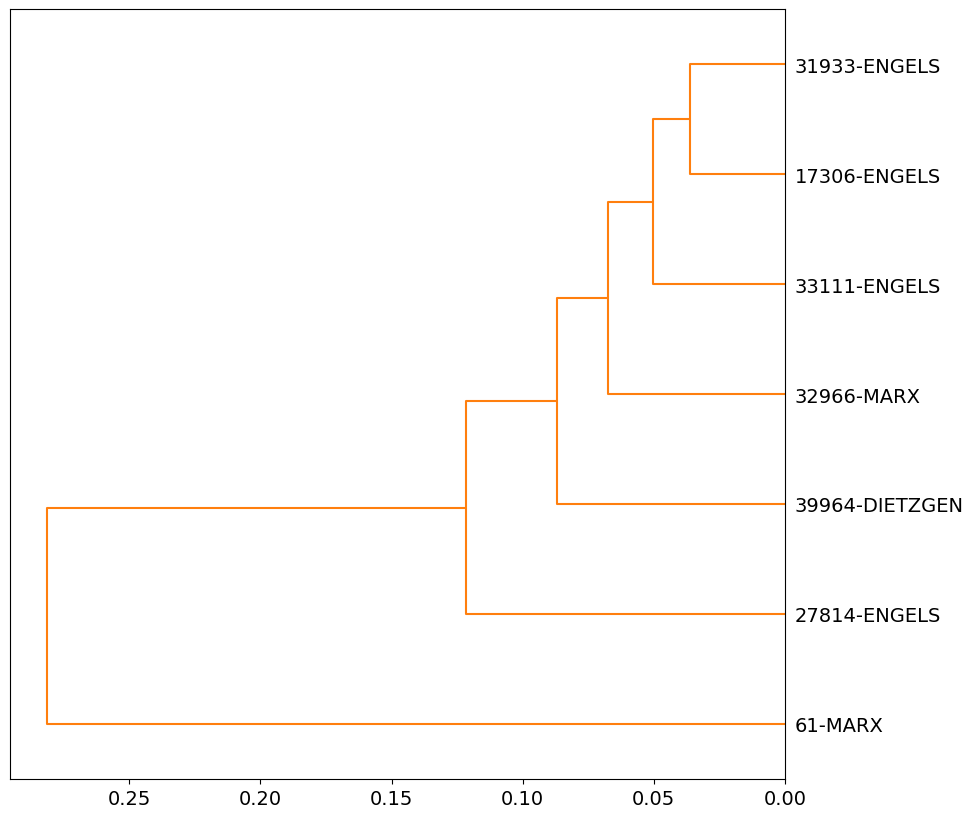

In [130]:
hca(PAIRS.jaccard, linkage_method='weighted', color_thresh=1)

#### Post-Work (Saving Files)

In [131]:
out_path = f'{data_home}/output/{data_prefix}'

In [132]:
LIB.to_csv(f'{out_path}-LIB.csv')
VOCAB.to_csv(f'{out_path}-VOCAB.csv')
CORPUS.to_csv(f'{out_path}-CORPUS.csv')
TFIDF_REDUCED.to_csv(f'{out_path}-PCATFIDF.csv')
PAIRS.to_csv(f'{out_path}-HCAPAIRS.csv')